# Lab 7: Event Selection Optimization

## William Olsen, partners with Jennifer Vo

Previously, we explored what the Higgs Boson is and some of it's properties (Lab 5).  In this lab we will explore how we can perform event selections in order to increase the significance of our Higgs measurement.  We had previously found that the significance for the discovery of the Higgs was quite low when using the whole data set - however through a series of data cuts we can optimize this significance and increase our confidence regarding the discovery of the Higgs Boson.  We will be using simulated data from the Large Haderon Collider with a transverse momentum between 1000 and 1200.

Before loading our data, let's recall that we have two sets of data: 100000 Higgs Boson simulated events, of which we have an expected yield of 50 and 100000 QCD background simulated events, of which we have an expected yield of 2000.  We also found that our QCD background is Poisson distributed with a parameter equal to the current expected yield of the QCD simulated data after a series of possible data cuts.  With these values, we can construct ratios to determine the percentage of simulated data that would correspond to a true lab event for both simulated sets of data: the Higgs set and the QCD set.

$$R_{higgs} = \frac{50}{100000} = 0.0005$$

$$R_{qcd} = \frac{2000}{100000} = 0.02$$

With these ratios if we now wanted to determine the expected yield of true lab measurements after a split we can.  We can calculate the expected yields for our Higgs events and our QCD events using the following formulas:

$$yield_{higgs} = N_{higgs}*R_{higgs}$$

$$yield_{qcd} = N_{qcd}*R_{qcd}$$

Where $N_{higgs}$ and $N_{qcd}$ are the number of Higgs and QCD simulated events, respectively, after a series of data cuts.

Lets begin by loading our data so we can explore optimizing our discovery sensitivity:

In [7]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pickle

# general graphing setup
plt.rcParams["figure.figsize"] = (15,10)

In [8]:
# open the file of interest, and use pickle loading
higgsfile = open ("higgs_100000_pt_1000_1200.pkl",'rb')
higgsdata = pickle.load(higgsfile)
qcdfile = open ("qcd_100000_pt_1000_1200.pkl",'rb')
qcddata = pickle.load(qcdfile)

### Problem 1

Now that we have loaded our data, let's make a stacked histogram of the feature variable mass.

In [9]:
def plot_stacked_hist(qcd, higgs, feature):
    bins = 100
    fs = 18
    
    # get the data
    feature_qcddata = qcd[f'{feature}']
    feature_higgsdata = higgs[f'{feature}']
    feature_data = [feature_qcddata, feature_higgsdata]
    
    # plot
    plt.hist(feature_data, bins=bins, stacked=True, label=['QCD Background counts', 'Higgs counts']) # add density=True for probability density
    plt.title('Stacked QCD background counts and Higgs counts', fontsize=fs)
    plt.xlabel(f' {feature}', fontsize=fs)
    plt.ylabel('Event counts', fontsize=fs)
    plt.tick_params(labelsize=fs)
    plt.legend()
    
    plt.show()

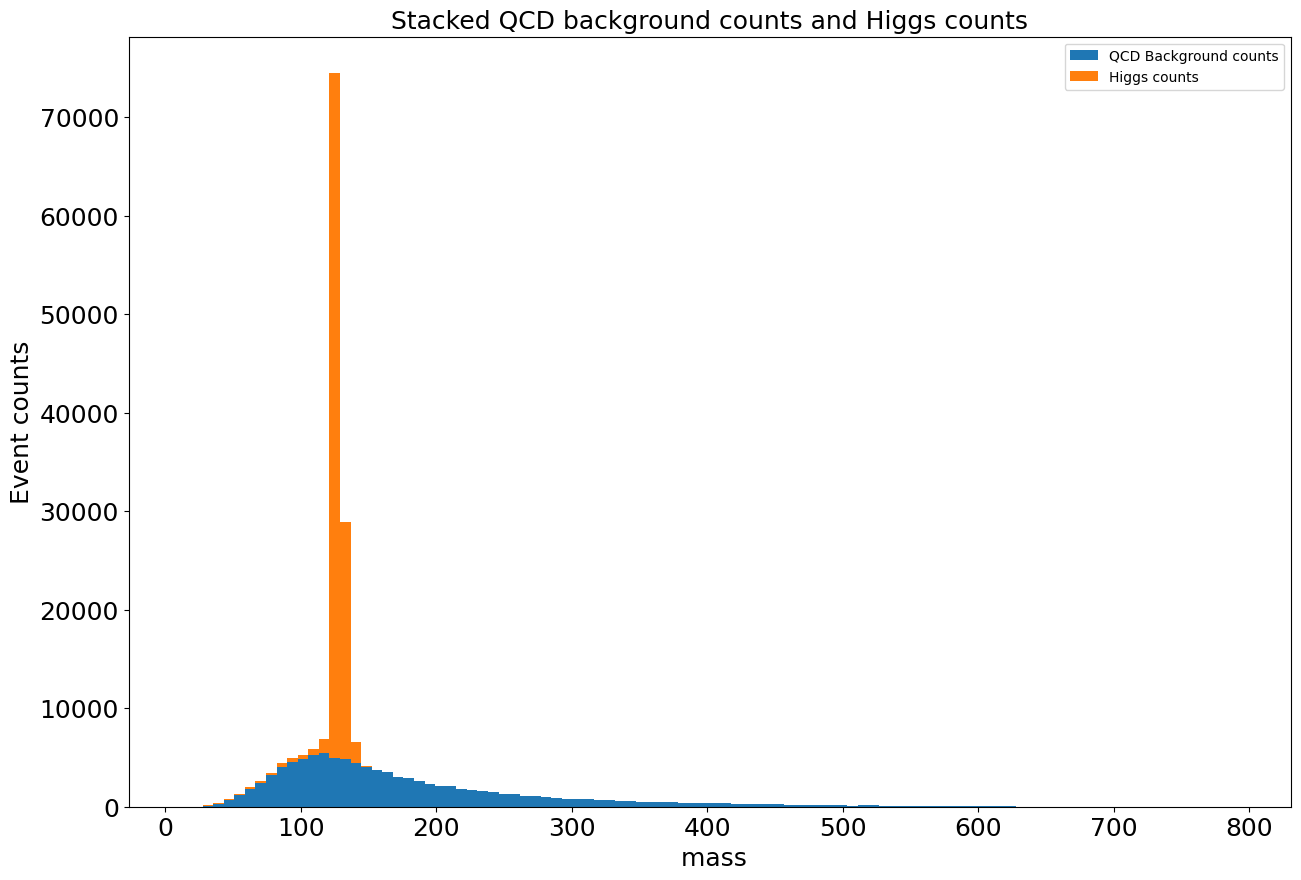

In [10]:
plot_stacked_hist(qcddata, higgsdata, 'mass')

We can see from above that the Higgs data is closely grouped around a small range of values while the QCD Background events are more spread out over different mass values.  Specifically from the plot above we observe that the mass of the events from the QCD distribution are widely spread from a value of around $0 \ GeV/c^2$ to $700 \ GeV/c^2$ but for the Higgs distribution the mass of the events almost always lie within the range $50 \ GeV/c^2$ to $150 \ GeV/c^2$. As expected, the range of values covered by the Higgs Boson events is smaller than that of the QCD background events.  This was our expectation because we know that the Higgs Boson should have a mass around $125 \ GeV/c^2$.

Now that we have visualized this stacked histogram, let's calculate the expected significance associated with the Higgs Boson without any event selections.  As previously stated, our background is Poisson distribution so we will use Poisson statistics for the significance calculation.  Let's calculate this significance by answering the following question:

> What is the significance of my signal of 2050 jets provided the QCD background, which is a Poisson distribution with parameter 2000 jets?

Our signal is 2050 because that is the expected yield of the QCD background and the Higgs Boson data added together and our parameter for the Poisson background is dictated by the expected yield of the QCD background.  Now we can calculate this signficance:

In [11]:
def compute_poisson_sigma_value(lambda_, value):
    # determine the probability associated with this value
    value_prob = stats.poisson.sf(value, lambda_)

    # use the inverse survival function to determine the sigma that has the same associated probability
    sigma = stats.norm.isf(value_prob)

    return sigma

def compute_poisson_specific_sigma_value(sigma, lambda_):
    # use the inverse survival function to determine the probability associated with 5sigma
    prob_sigma = stats.norm.sf(sigma)
    
    # determine the value associated with this probability
    value = stats.poisson.isf(prob_sigma, lambda_)

    return value

In [12]:
# define our variables
signal_0 = 2050
lambda_0 = 2000

# compute and print the significance for our signal
signal_0_sigma = compute_poisson_sigma_value(lambda_0, signal_0)
print(f'The significance of our signal of {signal_0} jets is {signal_0_sigma:.4f} sigma.')

The significance of our signal of 2050 jets is 1.1282 sigma.


We can see that the significance of our signal is only $1.1282\sigma$ but we need a significance of $5\sigma$ to claim a discovery.  We can compare this exact significance to an approximation of the significance which can be caluclated in the following way:

$$\sigma_{approx} = \frac{N_{higgs}}{\sqrt{N_{qcd}}} = \frac{50}{\sqrt{2000}} = 1.1180$$

Comparing these two values we see that the approximation is quite close to the exact sigma that we calculated of $1.128$ however they are not the same value.

# TODO - provide more of a response here regarding the 'equivalence' between the two values?

### Problem 2

Now that we have computed the base significance of the data - $1.1282\sigma$ - let's experiment with different data cuts on the mass feature and see how our significance changes for each data cut.  We previously observed that the Higgs Boson data largly lies between $50 \ GeV/c^2$ and $150 \ GeV/c^2$ so to find the best cut we will explore cuts of size 20 within this range.

We will begin with a cut from $50 \ GeV/c^2$ to $70 \ GeV/c^2$ where we keep all of the data from the Higgs Boson set and the QCD background set that have a mass between these two values and we will calculate our signficance.  Once we have done this cut  we will increment our window start and end by $10 \ GeV/c^2$ and compute the signficance for this new cut.  We will continue this process until the end value for our window reaches $150 \ GeV/c^2$.

Let's now perform these sequential cuts and determine which cut yields the best signficance:

In [19]:
def compute_yields(N_qcd, N_higgs):
    R_qcd = 2000 / 100000
    R_higgs = 50 / 100000
    
    return int(N_qcd * R_qcd), int(N_higgs * R_higgs)

def slice_data(qcd, higgs, feature, min_value, max_value):
    # cut the qcd background data
    qcd_sliced = qcd.drop(qcd[qcd[feature] < min_value].index)
    qcd_sliced = qcd_sliced.drop(qcd_sliced[qcd_sliced[feature] > max_value].index)
    
    # cut the higgs boson data
    higgs_sliced = higgs.drop(higgs[higgs[feature] < min_value].index)
    higgs_sliced = higgs_sliced.drop(higgs_sliced[higgs_sliced[feature] > max_value].index)
    
    # now that we have sliced the data lets get the new data counts and new yields
    N_qcd = len(qcd_sliced)
    N_higgs = len(higgs_sliced)
    yield_qcd, yield_higgs = compute_yields(N_qcd, N_higgs)
    
    # now that we have the new yields we can compute the new significance
    signal = yield_qcd + yield_higgs
    lambda_ = yield_qcd
    signal_sigma = compute_poisson_sigma_value(lambda_, signal)
    print(f'After a cut on the data with respect to feature {feature} between values {min_value} and {max_value} the discovery significance became {signal_sigma:0.4f} sigma.\n')
#     print((f'After a cut on the current data with respect to the feature <{feature}> keeping values between {min_value}\n'
#            f'and {max_value} we found that N_qcd = {N_qcd} and N_higgs = {N_higgs} with respective yields yield_qcd = {yield_qcd}\n'
#            f'and yield_higgs = {yield_higgs}.  This result yields a significance of {signal_sigma:0.4f} sigma for our signal value of {signal}.\n'))
    
    return qcd_sliced, higgs_sliced, signal_sigma

def iterative_slices(qcd, higgs, feature, start, end, width, increment):
    min_values = []
    max_values = []
    qcd_sliced = []
    higgs_sliced = []
    signal_sigma = []
    
    min_value = start
    max_value = start + width
    best_sigma = -100
    best_sigma_index = -1
    while max_value <= end:
        curr_qcd_sliced, curr_higgs_sliced, curr_signal_sigma = slice_data(qcddata, higgsdata, feature, min_value, max_value)
        
        # store the values for this iteration
        min_values.append(min_value)
        max_values.append(max_value)
        qcd_sliced.append(curr_qcd_sliced)
        higgs_sliced.append(curr_higgs_sliced)
        signal_sigma.append(curr_signal_sigma)
        
        # update our best result if needed
        if curr_signal_sigma > best_sigma:
            best_sigma = curr_signal_sigma
            best_sigma_index = len(signal_sigma) - 1
            
        # increment
        min_value += increment
        max_value += increment
        
    # return only the best information
    return qcd_sliced[best_sigma_index], higgs_sliced[best_sigma_index], signal_sigma[best_sigma_index], min_values[best_sigma_index], max_values[best_sigma_index]
        

In [20]:
mass_best_qcd_sliced, mass_best_higgs_sliced, mass_best_signal_sigma, mass_best_min_value, mass_best_max_value = iterative_slices(qcddata, higgsdata, 'mass', 50, 150, 20, 10)

After a cut on the data with respect to feature mass between values 50 and 70 the discovery significance became 0.0750 sigma.

After a cut on the data with respect to feature mass between values 60 and 80 the discovery significance became 0.0606 sigma.

After a cut on the data with respect to feature mass between values 70 and 90 the discovery significance became 0.0507 sigma.

After a cut on the data with respect to feature mass between values 80 and 100 the discovery significance became 0.0451 sigma.

After a cut on the data with respect to feature mass between values 90 and 110 the discovery significance became 0.0426 sigma.

After a cut on the data with respect to feature mass between values 100 and 120 the discovery significance became 0.1019 sigma.

After a cut on the data with respect to feature mass between values 110 and 130 the discovery significance became 2.3085 sigma.

After a cut on the data with respect to feature mass between values 120 and 140 the discovery significanc

The above information is quite muddled so lets print the information associated with which data cut provided the highest significance:

In [44]:
print((f'The slice that provided the highest significance of {mass_best_signal_sigma:0.4f} sigma was when we kept\n'
       f'the events with a mass between the values {mass_best_min_value} and {mass_best_max_value}\n'))

print(f'{(1 - len(mass_best_qcd_sliced) / len(qcddata)) * 100:0.2f}% of the QCD background data was eliminated in this split.')
print(f'{(1 - len(mass_best_higgs_sliced) / len(higgsdata)) * 100:0.2f}% of the Higgs Boson data was eliminated in this split.')

The slice that provided the highest significance of 2.9261 sigma was when we kept
the events with a mass between the values 120 and 140

87.48% of the QCD background data was eliminated in this split.
4.78% of the Higgs Boson data was eliminated in this split.


After performing the nine mass cuts above we found that the mass cut that provided the highest significance is when we slice the data with respect to the feature mass and keep all events with a mass between $120 \ GeV/c^2$ and $140 \ GeV/c^2$.  Now that we have this value we can decide if we would like to continue to cut the data further with this mass cut as a baseline split.

### Problem 3

To determine how we might proceed given the mass cut that we found previously lets plot two stacked histograms for each feature.  The first plot will be a stacked histogram of the QCD and Higgs event counts with respect to the current feature provided that the mass cut has not been performed.  The second plot will be of the event counts for both QCD and Higgs again but after the mass cut has been performed.  Let's generate these plots for each feature:

In [24]:
def plot_stacked_hist_comparison(qcd, higgs, qcd_sliced, higgs_sliced, feature, cut_desc):
    bins = 100
    fs = 10
    
    # get the data
    feature_qcddata = qcd[f'{feature}']
    feature_higgsdata = higgs[f'{feature}']
    feature_data = [feature_qcddata, feature_higgsdata]
    
    feature_qcddata_sliced = qcd_sliced[f'{feature}']
    feature_higgsdata_sliced = higgs_sliced[f'{feature}']
    feature_data_sliced = [feature_qcddata_sliced, feature_higgsdata_sliced]
    
    # plot the base stacked histogram
    plt.subplot(2, 1, 1)
    plt.hist(feature_data, bins=bins, stacked=True, label=['QCD Background counts', 'Higgs counts']) # add density=True for probability density
    plt.title('Stacked QCD background counts and Higgs counts', fontsize=fs)
    plt.xlabel(f' {feature}', fontsize=fs)
    plt.ylabel('Event counts', fontsize=fs)
    plt.tick_params(labelsize=fs)
    plt.legend()
    
    # plot the stacked histogram after the slice
    plt.subplot(2, 1, 2)
    plt.hist(feature_data_sliced, bins=bins, stacked=True, label=['QCD Background counts', 'Higgs counts']) # add density=True for probability density
    plt.title(f'Stacked QCD background counts and Higgs counts {cut_desc}', fontsize=fs)
    plt.xlabel(f' {feature}', fontsize=fs)
    plt.ylabel('Event counts', fontsize=fs)
    plt.tick_params(labelsize=fs)
    plt.legend()
    
    plt.show()

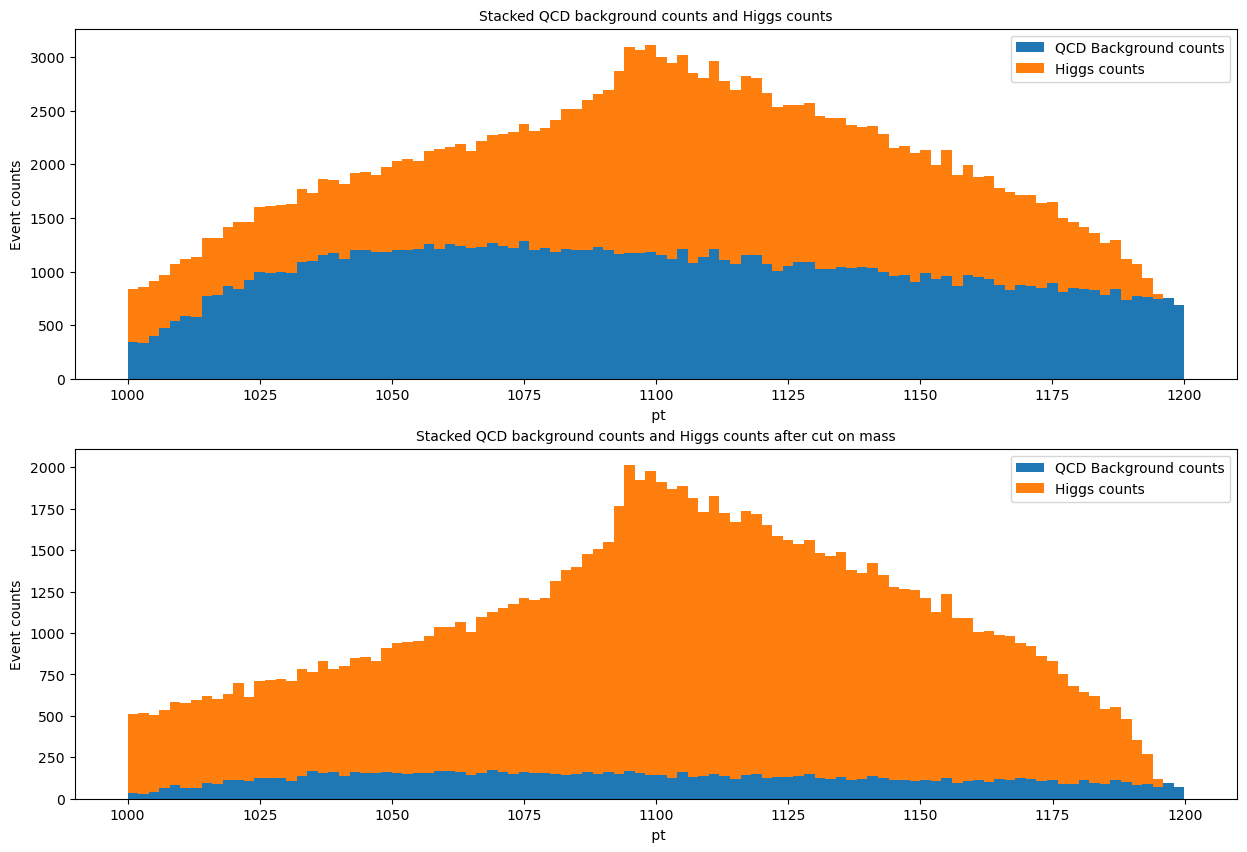

In [25]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 'pt', 'after cut on mass')

We see that before and after the cut the Higgs data and the QCD data are both spread out throughout the range of pT values thus there is not much motivation to split on this feature until possibly much much later.  Currently a cut on this feature would not be productive as it would throw out more Higgs than background.

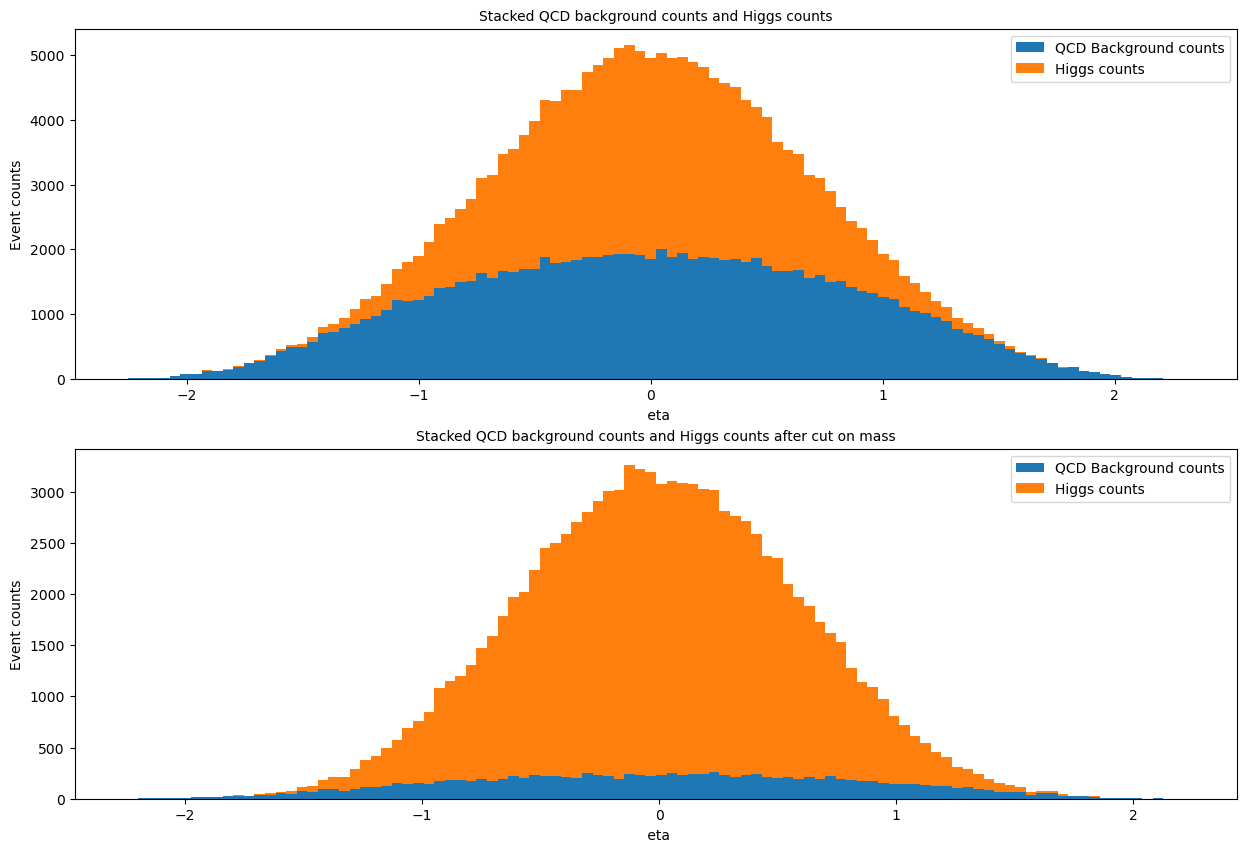

In [26]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 'eta', 'after cut on mass')

We see above that after the mass cut the number of QCD events was drastically decreased however the Higgs events seem to be Gaussian distributed so a cut on this feature would not be productive as it would throw out more Higgs than background.

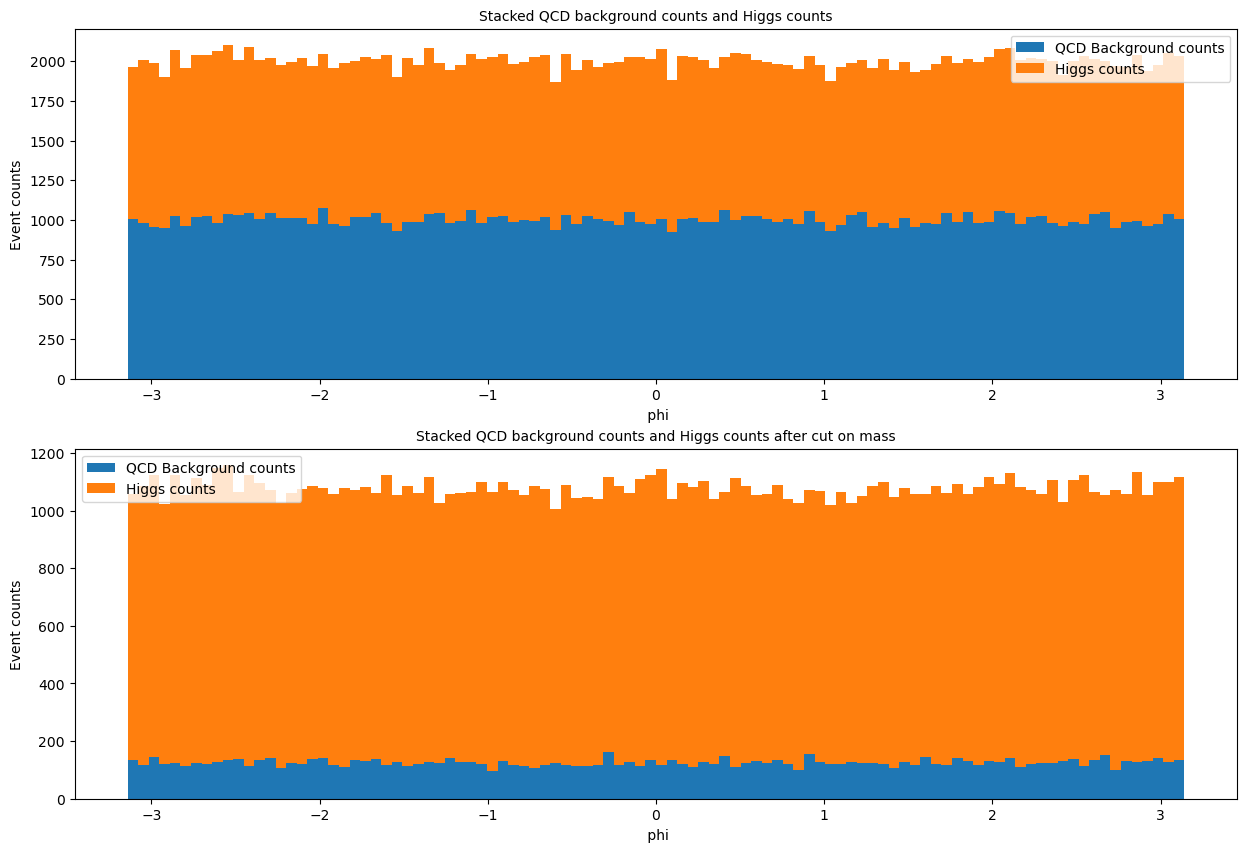

In [27]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 'phi', 'after cut on mass')

We previously found that phi was not a discriminatory feature thus a cut on this feature would not be productive as it would throw out more Higgs than background.

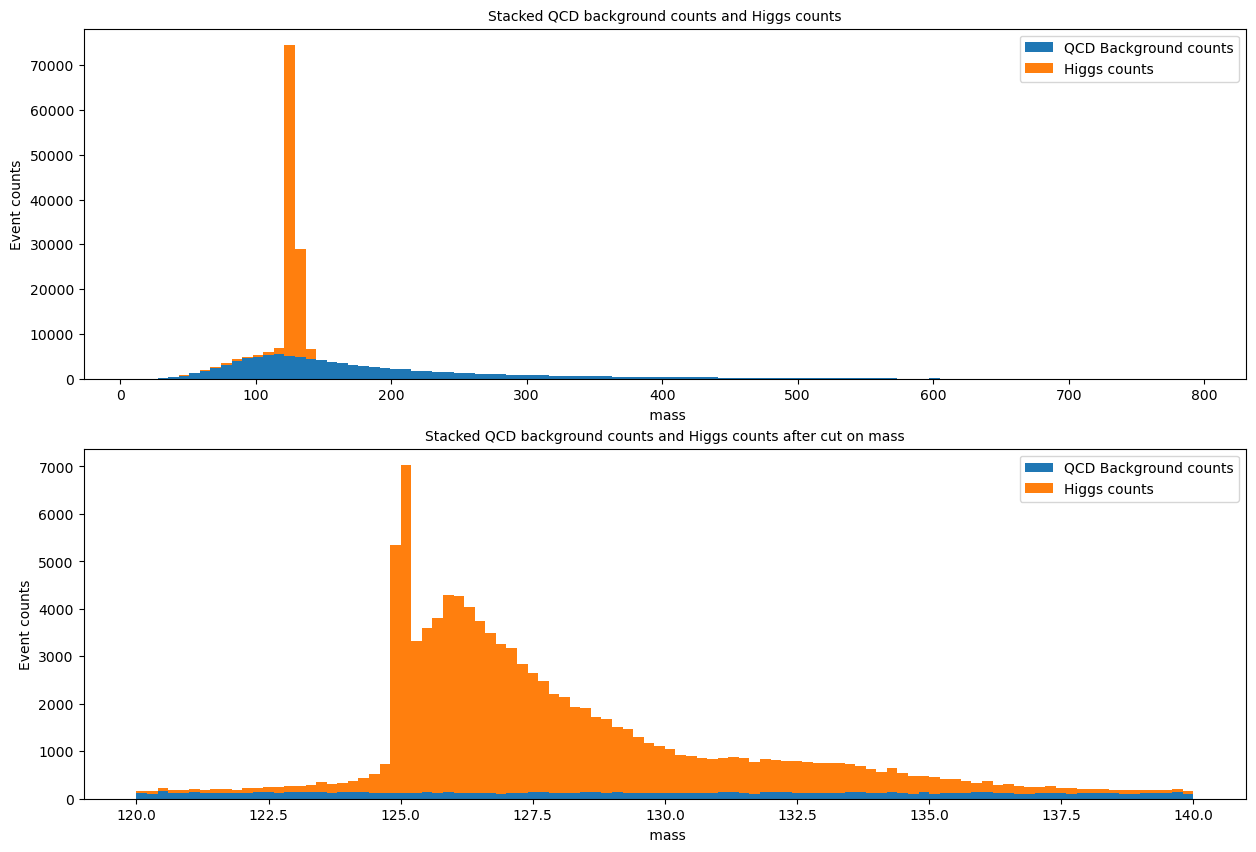

In [28]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 'mass', 'after cut on mass')

We can see above that the mass cut made provided a drastic improvement in decreasing the number of QCD events however looking at the histogram produced after the cut we can see that there may be another cut that could be made between 124 and 135 to improve our significance but this process may not be as productive as we think because we would be throwing out a noticable portion of our Higgs data when compared to how much background we would eliminate.  Something to possibly consider for a cut later in the process.

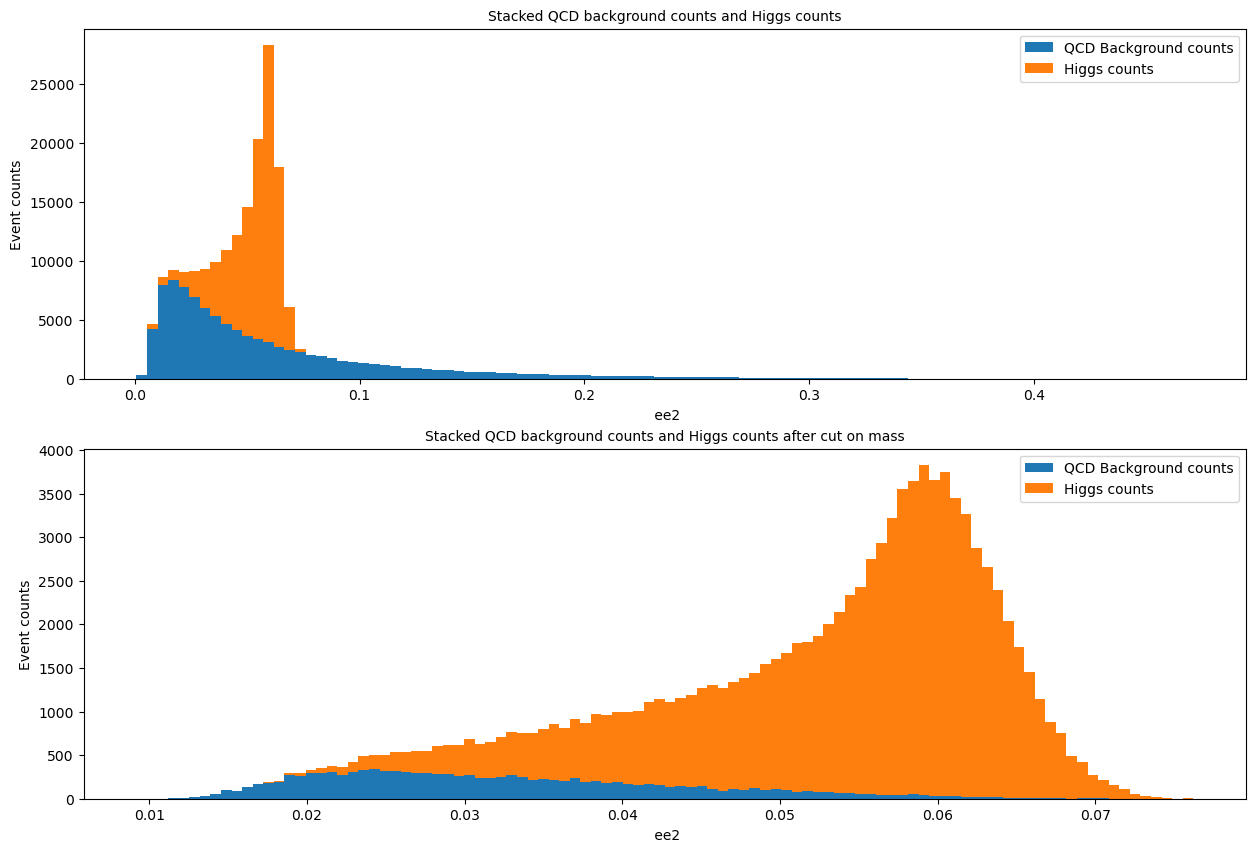

In [29]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 'ee2', 'after cut on mass')

From the above we see that splitting on ee2 may have been a desireable split in the beginning it would not have been as desireable as splitting on the mass.  When looking at after the split we see that there is an opportunity to make a split that will eliminate many of the background events while maximizing the number of Higgs events in our data set.

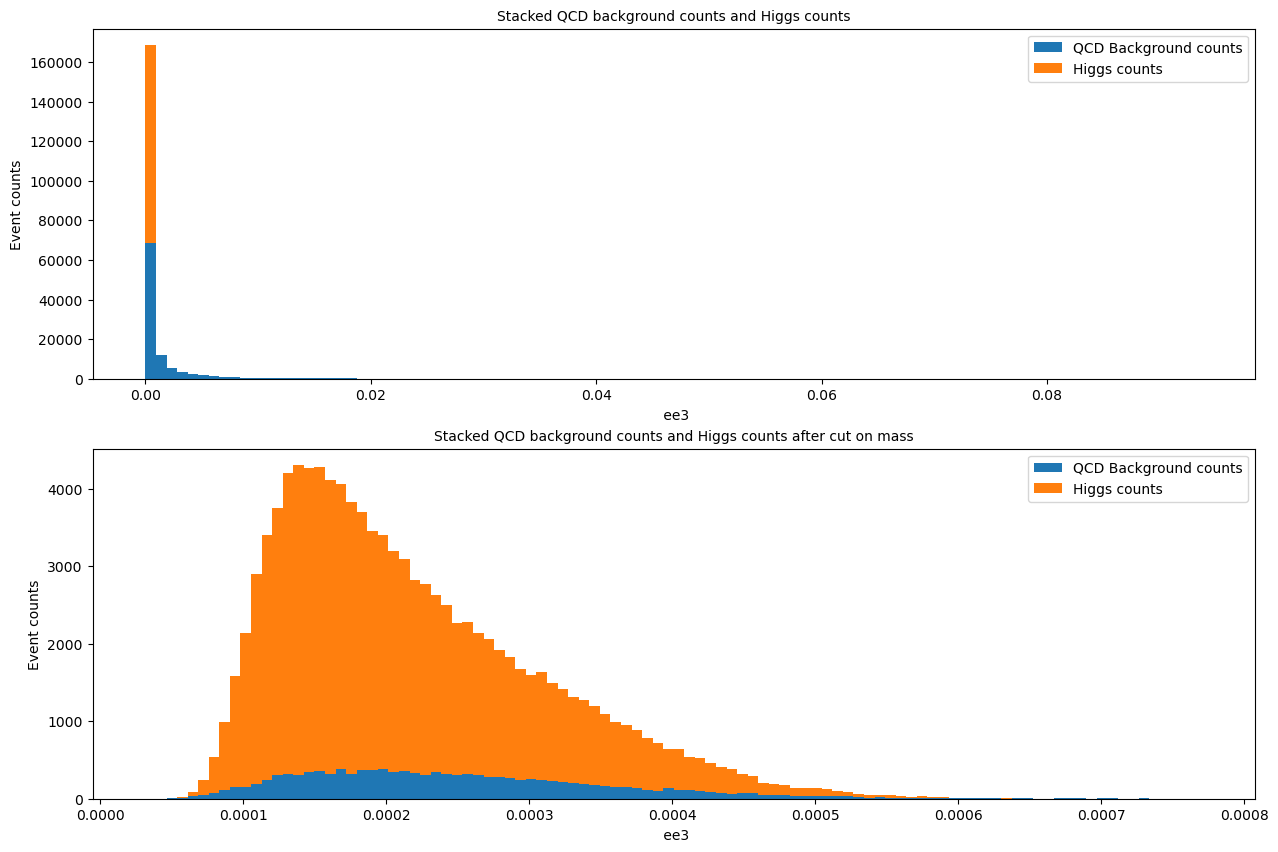

In [30]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 'ee3', 'after cut on mass')

From the above plots we see that this feature is not very desireable to split on as both the background and the Higgs data sets have very similar peaks so splitting on this feature could result in negative returns.

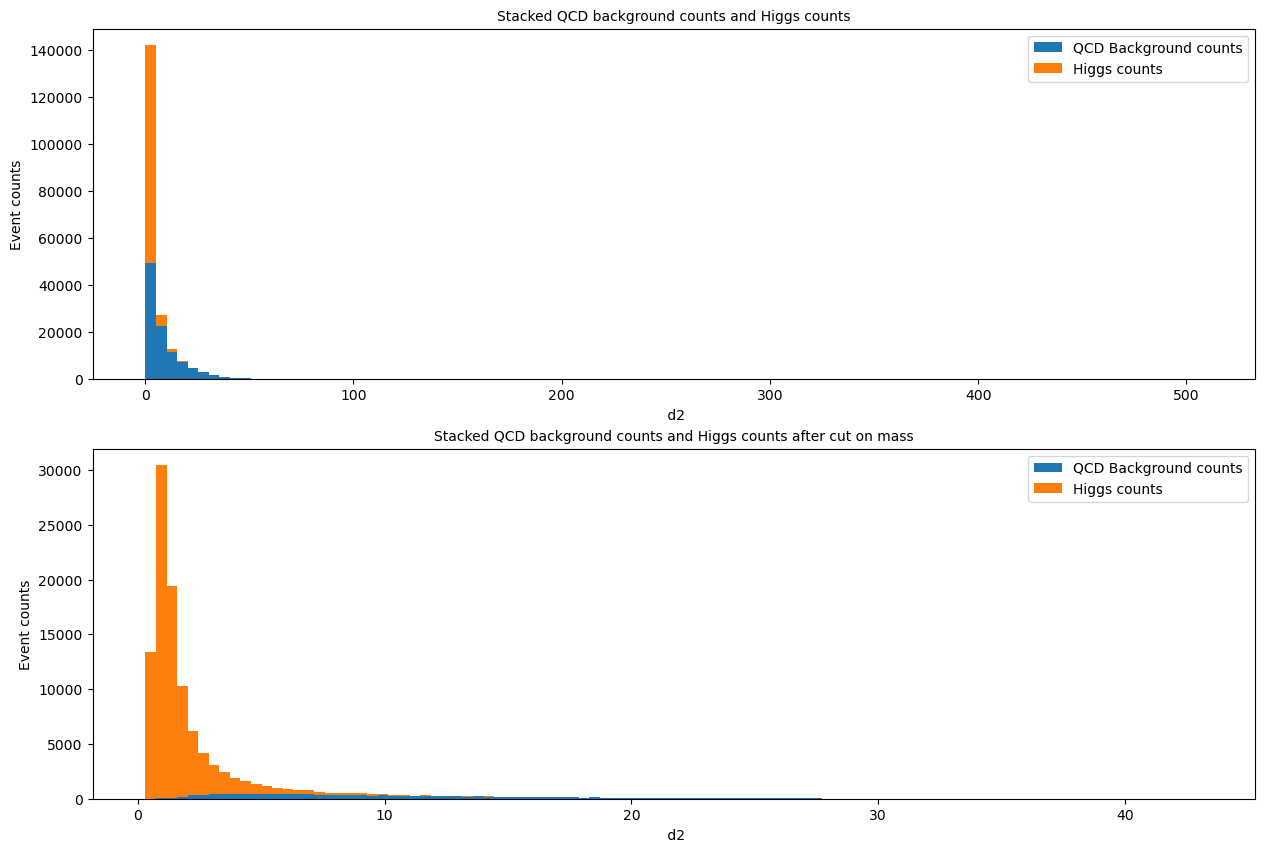

In [31]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 'd2', 'after cut on mass')

From the above plot we see that orginally splitting on this feature was not very desireable however after the split there is an opportunity to throw away some of the background events without throwing away almost any of the Higgs events.  This split could be keeping values between 0 and 10.

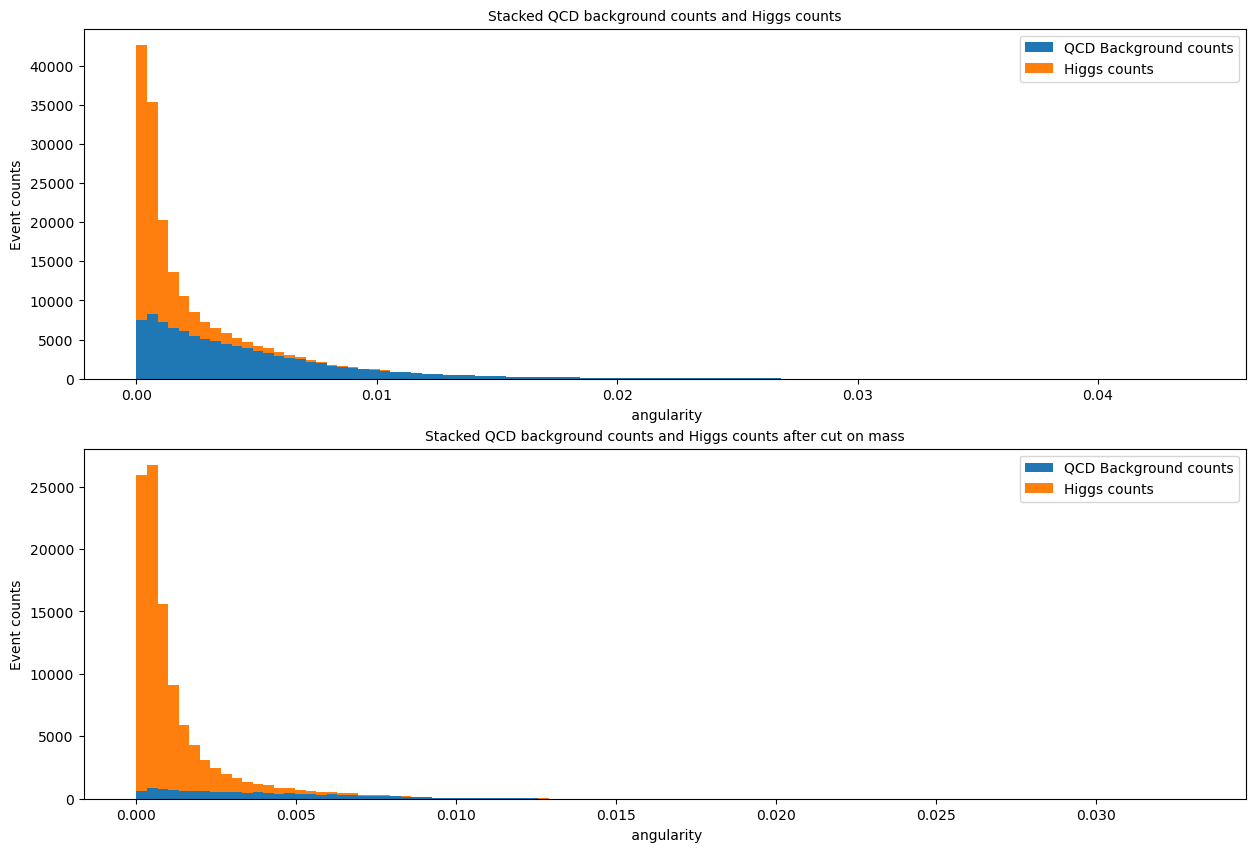

In [32]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 'angularity', 'after cut on mass')

From the aboce plots we see that before the mass split both the background and Higgs data had very similar peaks with respect to the feature angularity but that does not mean that there was not an opportunity to improve the signficance with a split.  After splitting we could imagine keeping data between 0 and 0.007 however this likely only provide a slight improvement to the signficance.

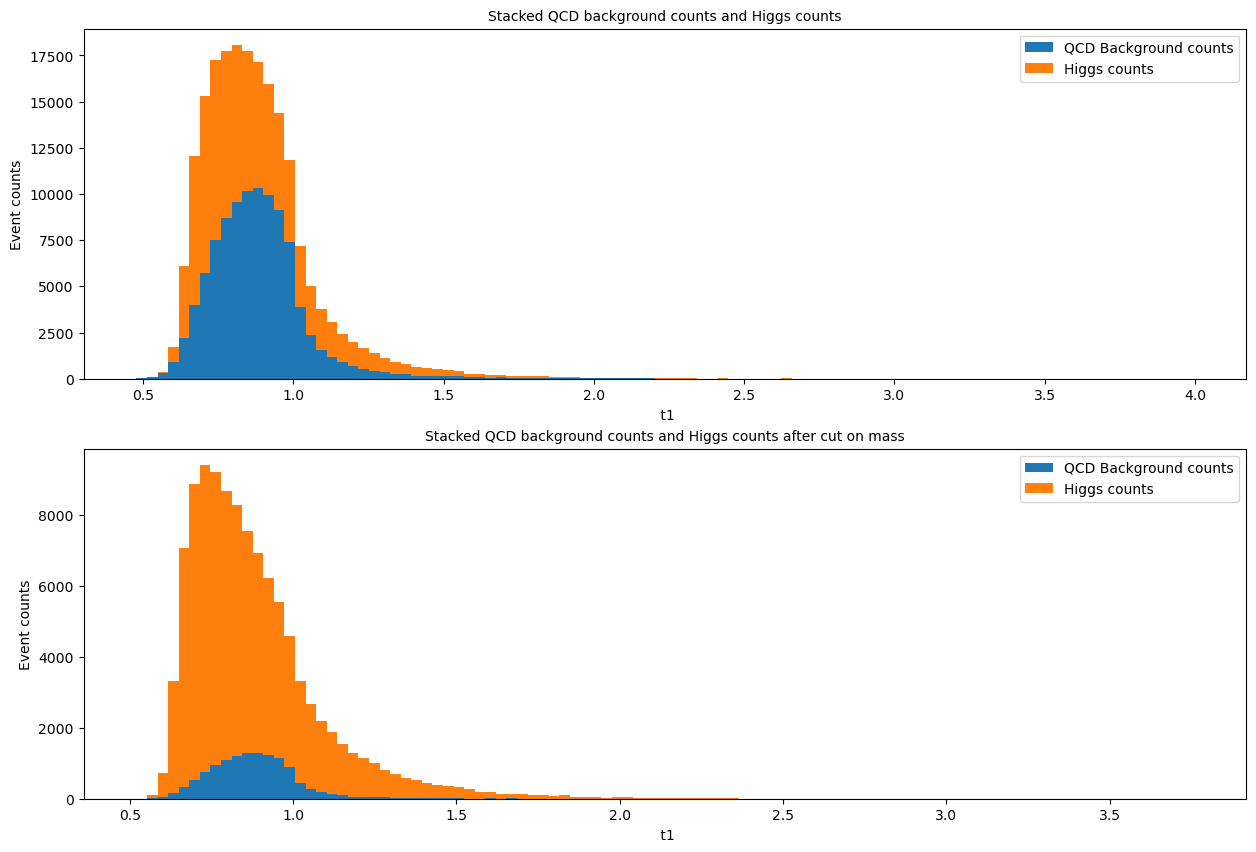

In [33]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 't1', 'after cut on mass')

From the above plots we see that before and after the split both the background and the Higgs data are highly coorelated so splitting on t1 is not desireable.

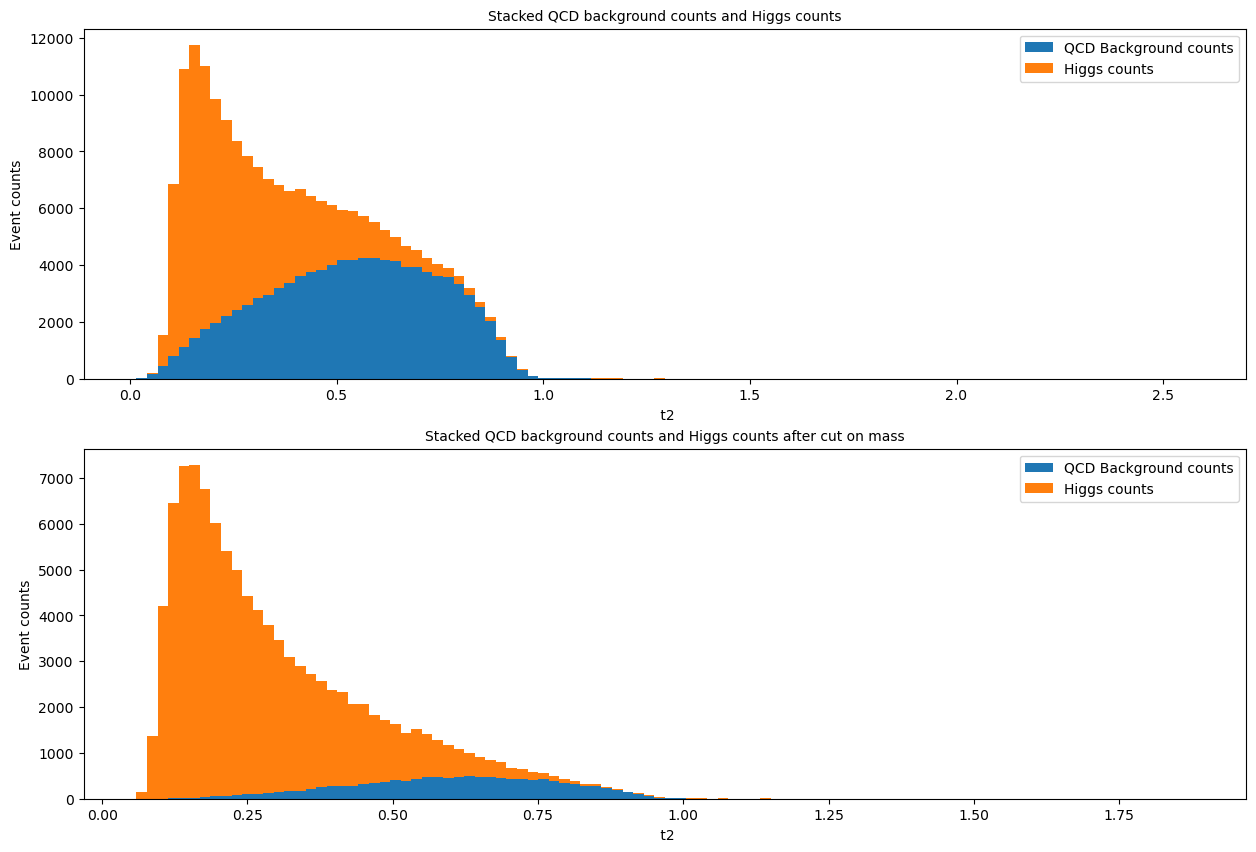

In [34]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 't2', 'after cut on mass')

From the above plots of t2 we can conclude that there is an opportunity to split on this feature to improve the significance if we were to split from 0 to 0.625 or 0.75.  Prior to the mass split this feature, while discrimanatory, does not provide a convincing argument to split on it.

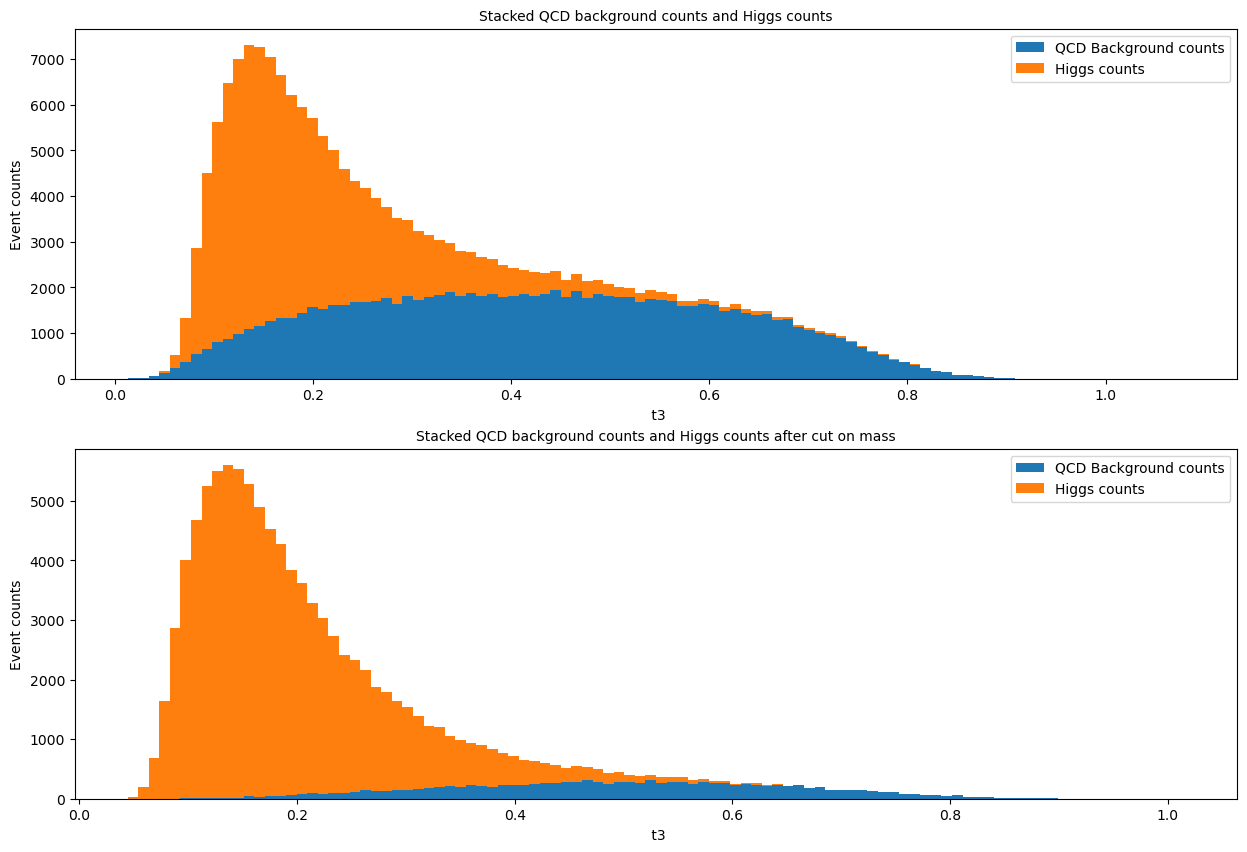

In [35]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 't3', 'after cut on mass')

From the above plot we see that splitting on t3 from 0 to 0.5 would have provided a great split to the data - eliminating nearly half of the background while preserving almost all of the Higgs data.  This split is great however it is not nearly as efficient as the mass split which eliminated nearly 87% of the background while only losing 5% of the Higgs data.  

After the mass split the opportunity to throw away nearly half of the background events is still avaliable if we were to split between 0 and 0.5.

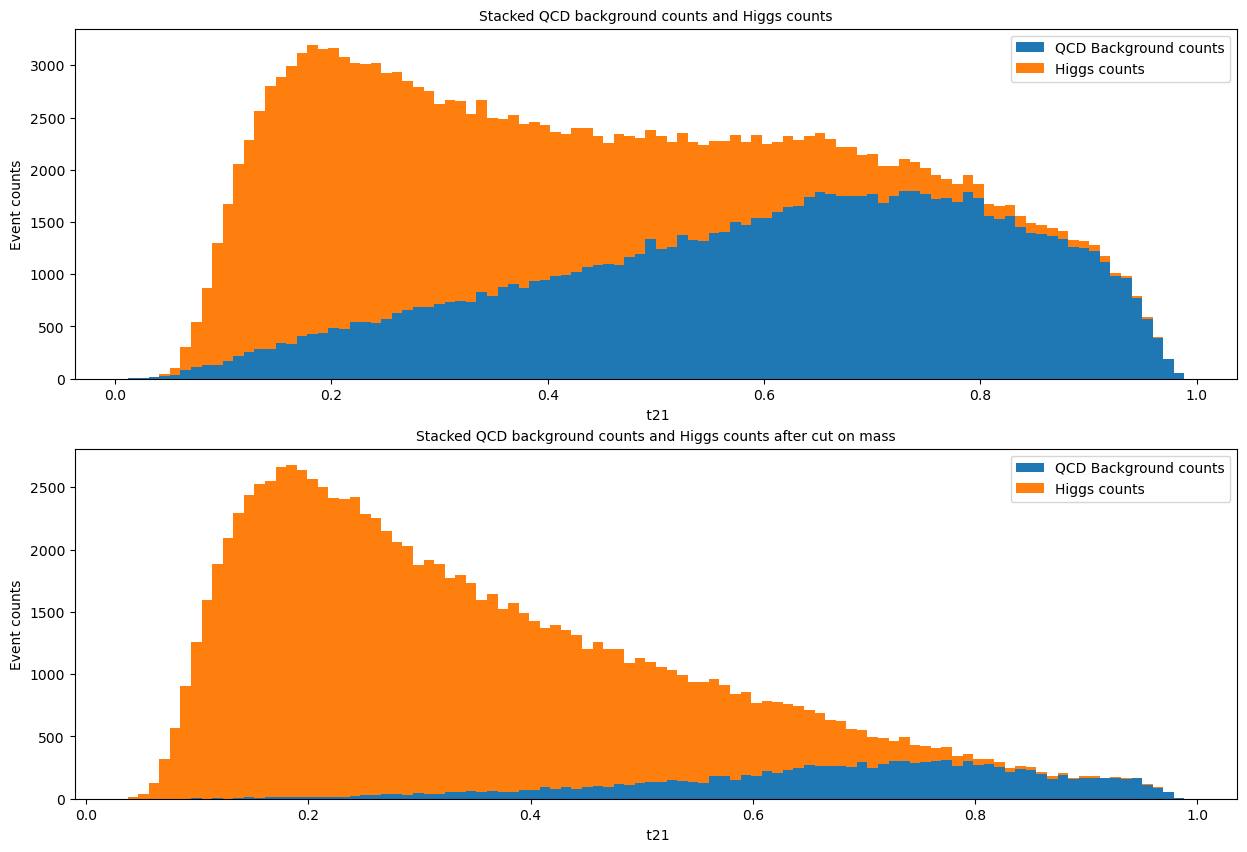

In [36]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 't21', 'after cut on mass')

Prior to the mass split we can conlude that while this feature is discriminatory, splitting on it would not provide the most desireable results when compared to other features.  After the mass split we can see an opportunity to split from around 0 to 0.75 which would eliminate much of the background while preserving the Higgs Boson data.

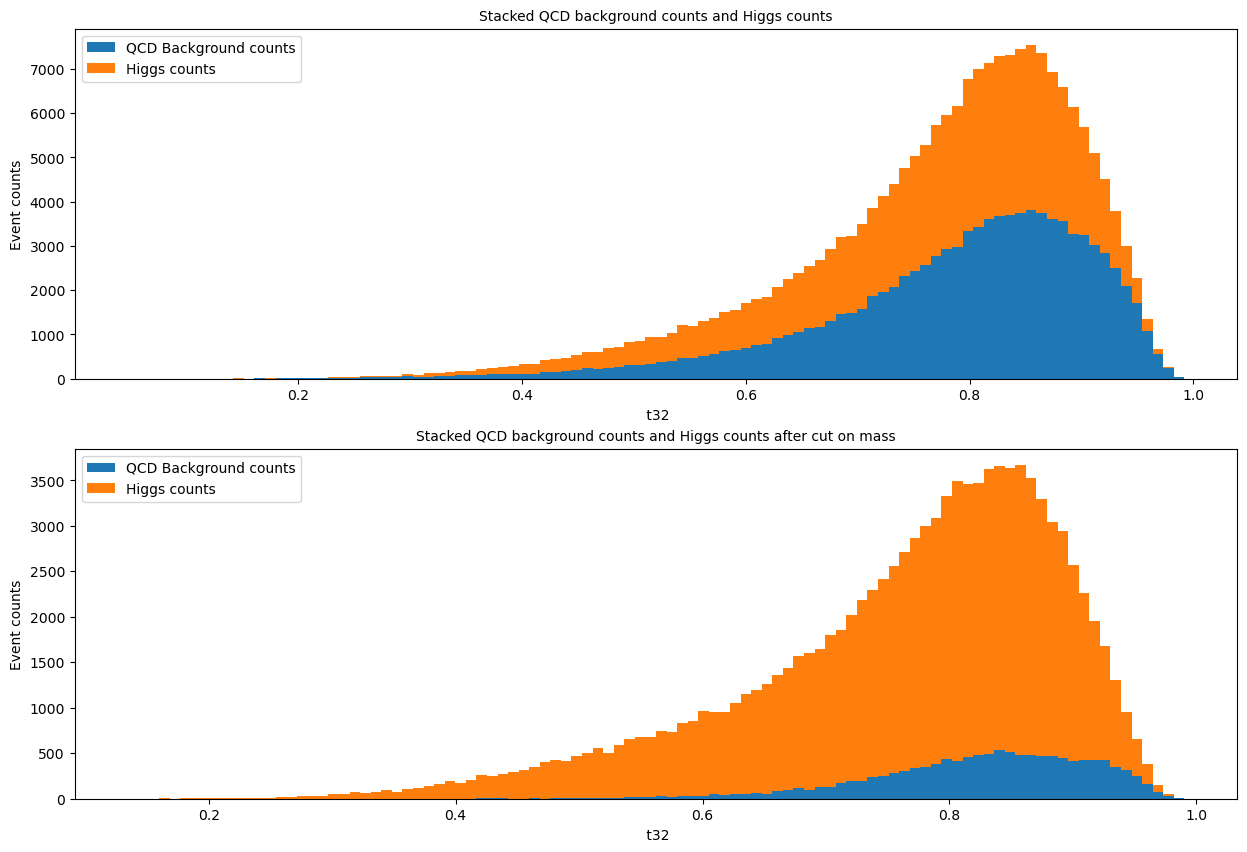

In [37]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 't32', 'after cut on mass')

We see from above that the peaks of the Higgs data and QCD data for the feature t32 are largly aligned before and after the mass split, thus this feature is not desireable to split on.  We also previously found that t32 does not provide discriminatory power so this result is not suprising.

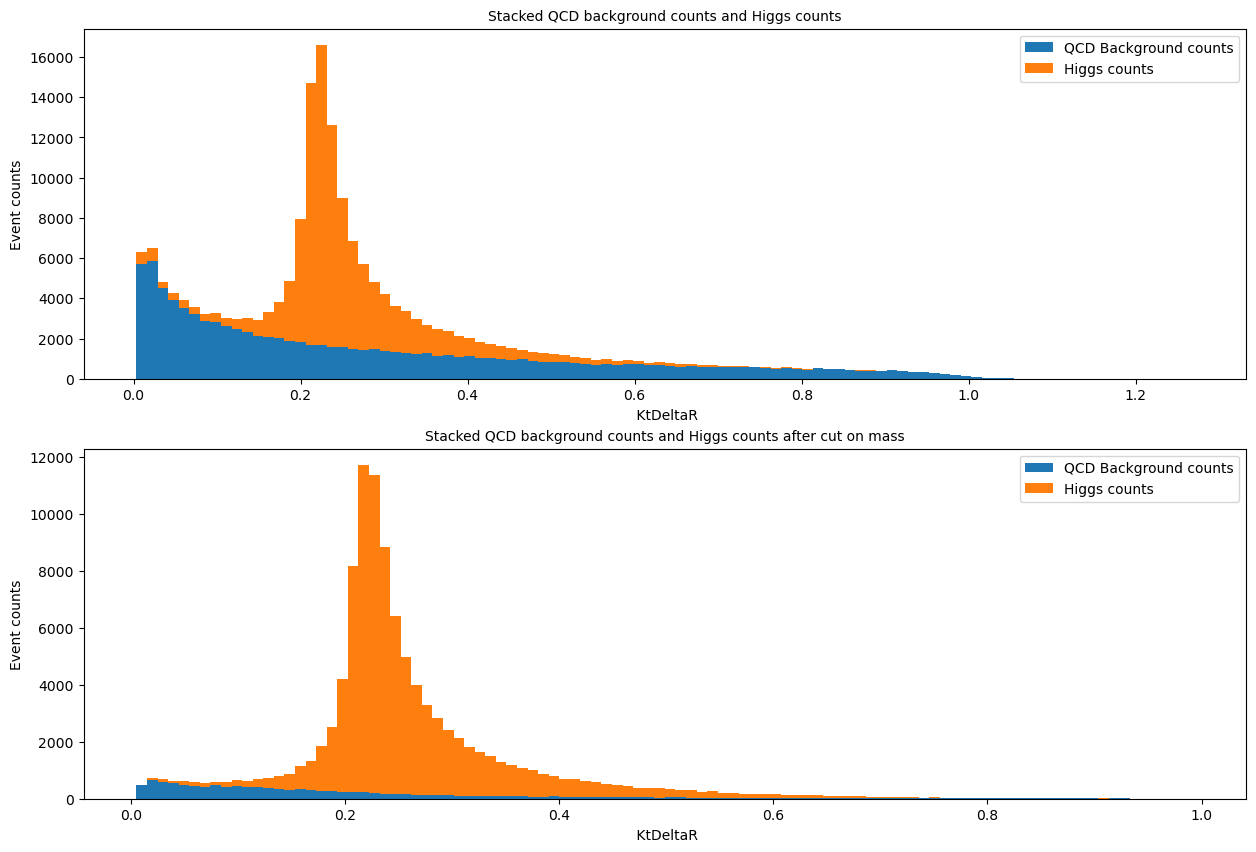

In [38]:
plot_stacked_hist_comparison(qcddata, higgsdata, mass_best_qcd_sliced, mass_best_higgs_sliced, 'KtDeltaR', 'after cut on mass')

Fromt he above we can see that prior to the split on mass there was an opportunity to remove a significant amount of the backgrund data while preserving much of the Higgs events if we were to keep events between 0.1 and 0.4 but this split would not provide an improvement as noticable as as the split on mass.  After splitting on mass we see that there is still an opportunity to improve the signficance of our measurement with a split on the feature KtDeltaR by performing a similar split as previously outlined.  Specifically keeping events from 0.1 or 0.15 to 1.0.

To summarize the above findings, we found that none of the features would be as discrimnatory as the feature mass however the features KtDeltaR and t3 would be the next best features to perform the original split on.  Similarly, we found that KtDeltaR and t3 are also great features to split on after our original mass split.  Some runner up features to consider after the two previously mentioned features are t21, ee2, t2, d2, and angularity which would, approximately, provide improvements in the order listed: from best to worst.

### Problem 4

Provided the analysis done in the previous problem we will peform more splits on the data sets in an attempt to improve the significance.  We will first begin with comparing a few splits on KtDeltaR and t3 to find which feature should be split on second.  Once we have made this comparison we will split on the other feature third and then can decide to proceed accordingly with the results by possibly splitting further on t21, ee2, t2, d2, and angularity.